# Prediction of Credit Approval

## Part 2: Model Selection
### Algorithms Used: <br>
   1.Logistic Regression <br>
   2.Decision Tree <br>
   3.Support Vector Machine  <br>
   4.AdaBoost <br>
   5.Random Forest <br>
   6.Extra Tree Classifier <br>
   7.XGBoost <br>
   8.LightGBM <br>
   9.Multi-Layer Perceptron <br> 

---

### Load the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from ipynb.fs.defs.func import histogram, measures, evaluation_plot
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier , ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, ConfusionMatrixDisplay
from yellowbrick.classifier import ROCAUC
from tabulate import tabulate

In [2]:
import sklearn
print(sklearn.__version__)

1.3.1


### Load Preprocessed Dataset

In [2]:
with open('x_train.pickle', 'rb')as file:
    x_train=pickle.load(file)
    
with open('x_test.pickle', 'rb')as file:
    x_test=pickle.load(file)
    
with open('y_train.pickle', 'rb')as file:
    y_train=pickle.load(file)
    
with open('y_test.pickle', 'rb')as file:
    y_test=pickle.load(file)

In [3]:
x_train.shape, x_test.shape

((552, 42), (138, 42))

### Creating and Saving Cross-Validation Folds in an Excel Workbook

In [4]:
kf = KFold(n_splits=5, random_state=0, shuffle= True)

In [5]:
fold_data = []

for fold, (train_index, val_index) in enumerate(kf.split(x_train), 1):
    x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    fold_data.append((x_train_fold, x_val_fold, y_train_fold, y_val_fold))

# Create an Excel writer object
writer = pd.ExcelWriter('', engine='xlsxwriter')

# Save the fold data in separate sheets
for fold, (x_train_fold, x_val_fold, y_train_fold, y_val_fold) in enumerate(fold_data, 1):
    sheet_name = f'Fold {fold}'
    train_data = pd.concat([x_train_fold, y_train_fold], axis=1)
    val_data = pd.concat([x_val_fold, y_val_fold], axis=1)
    fold_data_concat = pd.concat([train_data, val_data], axis=0)
    fold_data_concat.to_excel(writer, sheet_name=sheet_name, index=True)

# Save the Excel file
writer.save()

---
# Hyperparameter Tuning and Classification 
---

### 1.Logistic Regression

In [6]:
imba_pipeline = make_pipeline(LogisticRegression())
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring ='accuracy',cv=kf)}")

LR_params = {
          'solver': ['lbfgs', 'liblinear', 'saga'],
          'C': [1, 2, 4],
          'max_iter': [1000, 2000, 3000],
          'class_weight': ['balanced', None],
          'random_state': [0]
}

new_params = {'logisticregression__' + key: LR_params[key] for key in LR_params}
grid_imba1 = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='accuracy', return_train_score=True)


LR= grid_imba1.fit(x_train, y_train)

print(f"Mean test score: {grid_imba1.cv_results_['mean_test_score']}, \nMean train score: {grid_imba1.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba1.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba1.best_params_}")


Cross Validation Score:[0.85585586 0.82882883 0.91818182 0.90909091 0.82727273]
Mean test score: [0.86604423 0.86964783 0.86604423 0.86604423 0.86964783 0.86604423
 0.86604423 0.86964783 0.86604423 0.86784603 0.86966421 0.86784603
 0.86784603 0.86966421 0.86784603 0.86784603 0.86966421 0.86784603
 0.86966421 0.87148239 0.86966421 0.86966421 0.87148239 0.86966421
 0.86966421 0.87148239 0.86966421 0.87328419 0.87146601 0.87328419
 0.87328419 0.87146601 0.87328419 0.87328419 0.87146601 0.87328419
 0.87146601 0.86966421 0.87146601 0.87146601 0.86966421 0.87146601
 0.87146601 0.86966421 0.87146601 0.87149877 0.86968059 0.87149877
 0.87149877 0.86968059 0.87149877 0.87149877 0.86968059 0.87149877], 
Mean train score: [0.88406132 0.88360985 0.88406132 0.88406132 0.88360985 0.88406132
 0.88406132 0.88360985 0.88406132 0.88678035 0.88723387 0.88632684
 0.88678035 0.88723387 0.88632684 0.88678035 0.88723387 0.88632684
 0.8890469  0.88949939 0.8890469  0.8890469  0.88949939 0.8890469
 0.8890469  

In [7]:
y_pred_LR = LR.predict(x_test)

In [8]:
LR_measurement = measures('Logistic Regression', y_test, y_pred_LR)

Logistic Regression Accuracy: 0.8261
Logistic Regression Precision: 0.7042
Logistic Regression Recall: 0.9434
Logistic Regression F1: 0.8065
Logistic Regression Cohen kappa: 0.6545


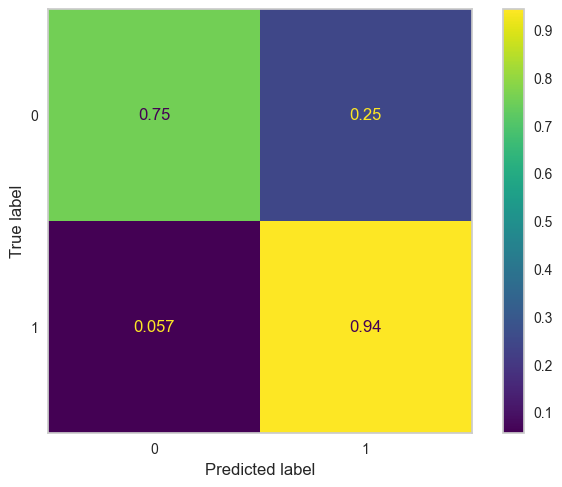

In [9]:
evaluation_plot(LR, x_test, y_test, y_pred_LR)

In [10]:
with open('LogisticRegression.pkl' , 'wb') as file:
  pickle.dump(LR, file)

### 2. Decision Tree

In [7]:
imba_pipeline = make_pipeline(DecisionTreeClassifier())
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring ='accuracy',cv=kf)}")

DT_params ={'criterion': ['gini', 'entropy'], 
            'max_depth': [2,3,4,5,6],
            'min_samples_leaf': [1, 2, 3, 4],
            'random_state': [0]}


new_params = {'decisiontreeclassifier__' + key: DT_params[key] for key in DT_params}
grid_imba2 = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf,
                         scoring='accuracy', return_train_score=True)

DT= grid_imba2.fit(x_train, y_train)

print(f"Mean test score: {grid_imba2.cv_results_['mean_test_score']}, \nMean train score: {grid_imba2.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba2.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba2.best_params_}")


Cross Validation Score:[0.8018018  0.8018018  0.76363636 0.84545455 0.82727273]
Mean test score: [0.86420966 0.86420966 0.86420966 0.86420966 0.8406552  0.8406552
 0.84067158 0.84067158 0.83146601 0.82969697 0.83511876 0.83511876
 0.81700246 0.82427518 0.84602785 0.84602785 0.81701884 0.82427518
 0.82794431 0.83698608 0.86420966 0.86420966 0.86420966 0.86420966
 0.86058968 0.86058968 0.86240786 0.86060606 0.83330057 0.83331695
 0.83878788 0.84776413 0.84419328 0.84244062 0.84787879 0.85506962
 0.83520066 0.83883702 0.842457   0.84602785], 
Mean train score: [0.8641354  0.8641354  0.8641354  0.8641354  0.87500539 0.87319338
 0.87319338 0.87273987 0.89900883 0.89765137 0.89266989 0.88904587
 0.9275423  0.91848534 0.91078277 0.90489221 0.94565826 0.93161778
 0.92300818 0.91666718 0.8641354  0.8641354  0.8641354  0.8641354
 0.86957039 0.8691179  0.86821087 0.87047537 0.89085378 0.88722874
 0.88224623 0.88134023 0.91757318 0.91123526 0.9035327  0.90036322
 0.9365972  0.92844625 0.9189327  0

In [8]:
y_pred_DT = DT.predict(x_test)

In [9]:
DT_measurement = measures('Decision Tree', y_test, y_pred_DT)

Decision Tree Accuracy: 0.8188
Decision Tree Precision: 0.6892
Decision Tree Recall: 0.9623
Decision Tree F1: 0.8031
Decision Tree Cohen kappa: 0.6437


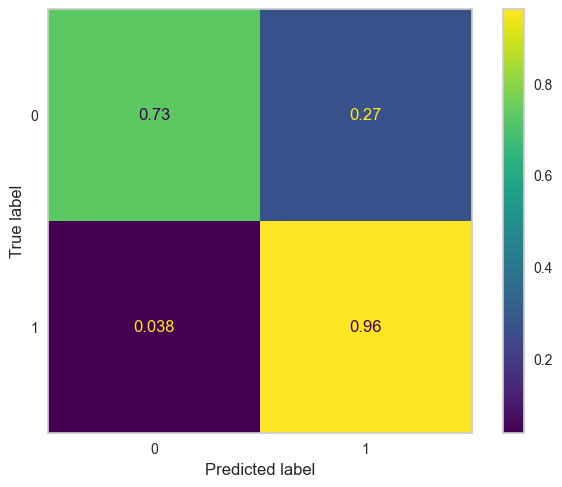

In [10]:
evaluation_plot(DT, x_test, y_test, y_pred_DT)

In [11]:
with open('DecisionTree.pkl' , 'wb') as file:
  pickle.dump(DT, file)

### 3. Support Vector Machine

In [16]:
imba_pipeline = make_pipeline(SVC())
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring ='accuracy',cv=kf)}")

svc_params = {'C': [0.001, 0.01,0.1],
              'kernel': ['rbf', 'poly', 'sigmoid','linear'],
              'max_iter': [110,120,130,140,150,160],
              'random_state': [0],
              'probability': [True]}

new_params = {'svc__' + key: svc_params[key] for key in svc_params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf,
                         scoring='accuracy', return_train_score=True)

svm= grid_imba.fit(x_train, y_train)

print(f"Mean test score: {grid_imba.cv_results_['mean_test_score']}, \nMean train score: {grid_imba.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba.best_params_}")


Cross Validation Score:[0.82882883 0.83783784 0.90909091 0.90909091 0.84545455]
Mean test score: [0.76460278 0.77544636 0.78445536 0.79719902 0.800819   0.7972154
 0.71217035 0.73051597 0.81166257 0.82612613 0.82974611 0.83511876
 0.55274365 0.56001638 0.54917281 0.55095823 0.54550369 0.55461097
 0.61094185 0.60006552 0.59642916 0.59642916 0.59823096 0.59095823
 0.78995905 0.79716626 0.840819   0.84982801 0.86420966 0.86420966
 0.86244062 0.85515152 0.84422604 0.8569697  0.86240786 0.87323505
 0.5563964  0.55823096 0.55279279 0.54738739 0.58914005 0.59094185
 0.86420966 0.86420966 0.86420966 0.86420966 0.86601147 0.86601147
 0.86602785 0.86784603 0.86784603 0.86240786 0.87505324 0.87505324
 0.86786241 0.87148239 0.86604423 0.86966421 0.86966421 0.87146601
 0.59092547 0.5818837  0.78602785 0.8605733  0.85695332 0.85875512
 0.86420966 0.86420966 0.86420966 0.86420966 0.86420966 0.86420966], 
Mean train score: [0.79572137 0.79437929 0.80299607 0.81702219 0.8174716  0.81113163
 0.7182514  

In [17]:
y_pred_SVM = svm.predict(x_test)

In [18]:
SVM_measurement = measures('Support Vector Machine', y_test, y_pred_SVM)

Support Vector Machine Accuracy: 0.8116
Support Vector Machine Precision: 0.6849
Support Vector Machine Recall: 0.9434
Support Vector Machine F1: 0.7937
Support Vector Machine Cohen kappa: 0.6282


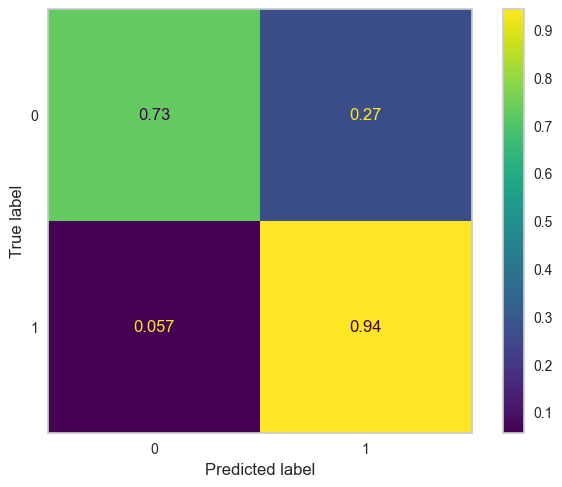

In [19]:
evaluation_plot(svm, x_test, y_test, y_pred_SVM)

### 4. AdaBoost

In [12]:
imba_pipeline = make_pipeline(AdaBoostClassifier())
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring ='accuracy',cv=kf)}")

AB_params = {'n_estimators': [ 100,110,120,150], 
             'learning_rate': [1.1,1.15,1.2,1.25],
             'random_state': [0]}

new_params = {'adaboostclassifier__' + key: AB_params[key] for key in AB_params}
grid_imba3 = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf,
                         scoring='accuracy', return_train_score=True)

AB= grid_imba3.fit(x_train, y_train)

print(f"Mean test score: {grid_imba3.cv_results_['mean_test_score']}, \nMean train score: {grid_imba3.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba3.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba3.best_params_}")


Cross Validation Score:[0.8018018  0.82882883 0.85454545 0.88181818 0.83636364]
Mean test score: [0.84058968 0.84060606 0.83693694 0.83693694 0.83520066 0.83153153
 0.83336609 0.83878788 0.82972973 0.82427518 0.82610975 0.82971335
 0.84609337 0.84060606 0.8351679  0.83515152], 
Mean train score: [0.9533516  0.95833821 0.96150768 0.96649019 0.95606961 0.95697766
 0.96195812 0.96830322 0.9574322  0.96332277 0.96558521 0.9710202
 0.96150665 0.96105622 0.96468023 0.97056566]
Grid search best score: 0.8461
Grid search best parameters: {'adaboostclassifier__learning_rate': 1.25, 'adaboostclassifier__n_estimators': 100, 'adaboostclassifier__random_state': 0}


In [13]:
y_pred_AB = AB.predict(x_test)

In [14]:
AB_measurement = measures('AdaBoost', y_test, y_pred_AB)

AdaBoost Accuracy: 0.8188
AdaBoost Precision: 0.7333
AdaBoost Recall: 0.8302
AdaBoost F1: 0.7788
AdaBoost Cohen kappa: 0.6264


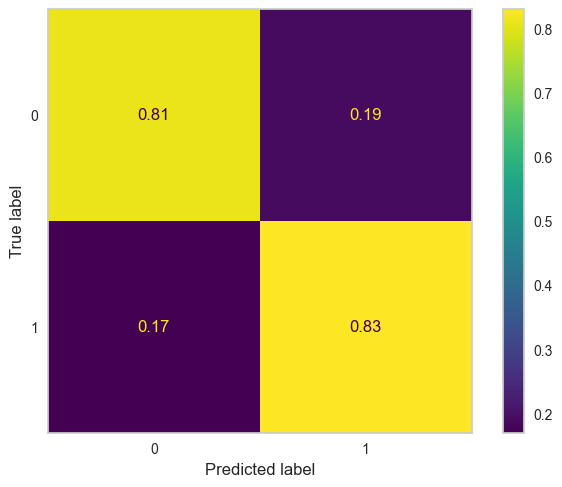

In [15]:
evaluation_plot(AB, x_test, y_test, y_pred_AB)

In [16]:
with open('AdaBoost.pkl' , 'wb') as file:
  pickle.dump(AB, file)

### 5. Random Forest

In [6]:
imba_pipeline = make_pipeline(RandomForestClassifier())
print(f"Cross validation score: {cross_val_score(imba_pipeline, x_train, y_train, scoring='accuracy', cv=kf)}")

# Grid search
params = {
    'n_estimators': [110,120,130,140,150],
    'max_depth': [13,14,15],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'random_state': [0]
}

new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='accuracy', return_train_score=True)

RF = grid_imba.fit(x_train, y_train)

print(f"Mean test score: {grid_imba.cv_results_['mean_test_score']}, \nMean train score: {grid_imba.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba.best_params_}")

Cross validation score: [0.84684685 0.87387387 0.9        0.9        0.85454545]
Mean test score: [0.8786896  0.87685504 0.87325143 0.87144963 0.87325143 0.87862408
 0.87864046 0.87683866 0.87503686 0.87865684 0.87867322 0.87687142
 0.87505324 0.87865684 0.87685504 0.87683866 0.87503686 0.87503686
 0.87683866 0.88227682 0.87321867 0.87503686 0.87683866 0.87503686
 0.87323505 0.87321867 0.87503686 0.87683866 0.87503686 0.87323505
 0.87867322 0.87685504 0.87685504 0.87867322 0.87685504 0.87505324
 0.87503686 0.87503686 0.87503686 0.87503686 0.86597871 0.87138411
 0.87321867 0.87140049 0.86778051 0.86597871 0.87138411 0.87321867
 0.87140049 0.86778051 0.86597871 0.87138411 0.87321867 0.87140049
 0.86778051 0.87323505 0.87323505 0.87141687 0.87141687 0.87141687
 0.87685504 0.87685504 0.87503686 0.87321867 0.87140049 0.87685504
 0.87685504 0.87503686 0.87321867 0.87140049 0.87685504 0.87685504
 0.87503686 0.87321867 0.87140049 0.87685504 0.87685504 0.87503686
 0.87321867 0.87140049 0.880491

In [7]:
y_pred_RF = RF.predict(x_test)

In [8]:
RF_measurement = measures('Random Forest', y_test, y_pred_RF)

Random Forest Accuracy: 0.8478
Random Forest Precision: 0.7759
Random Forest Recall: 0.8491
Random Forest F1: 0.8108
Random Forest Cohen kappa: 0.684


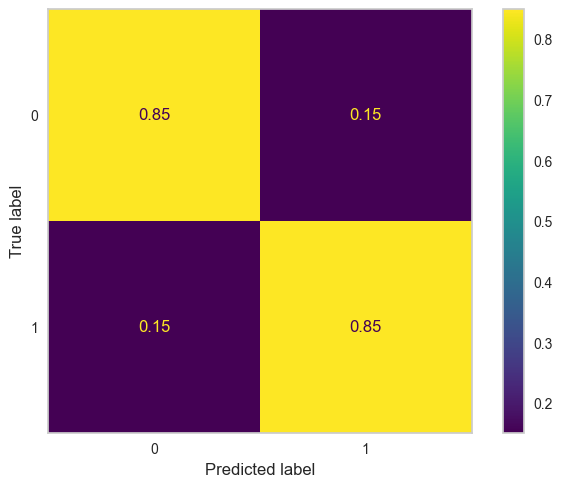

In [9]:
evaluation_plot(RF, x_test, y_test, y_pred_RF)

In [10]:
with open('RandomForest.pkl' , 'wb') as file:
  pickle.dump(RF, file)

### 6. Extra Tree Classifier

In [29]:
imba_pipeline = make_pipeline(ExtraTreesClassifier())
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring ='accuracy',cv=kf)}")
 
ET_params = {'n_estimators': [13,14,15,16,17],
             'max_depth': [1,2,3],
             'criterion': ['gini', 'entropy'],
             'min_samples_split': [3,5,7],
             'min_samples_leaf': [7,8,9],
             'random_state': [0]}

new_params = {'extratreesclassifier__' + key: ET_params[key] for key in ET_params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf,
                         scoring='accuracy', return_train_score=True)

ET= grid_imba.fit(x_train, y_train)

print(f"Mean test score: {grid_imba.cv_results_['mean_test_score']}, \nMean train score: {grid_imba.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba.best_params_}")

Cross Validation Score:[0.83783784 0.85585586 0.87272727 0.92727273 0.85454545]
Mean test score: [0.67367731 0.66283374 0.67372645 0.65736282 0.7552498  0.67367731
 0.66283374 0.67372645 0.65736282 0.7552498  0.67367731 0.66283374
 0.67372645 0.65736282 0.7552498  0.67367731 0.66283374 0.67372645
 0.65736282 0.7552498  0.67367731 0.66283374 0.67372645 0.65736282
 0.7552498  0.67367731 0.66283374 0.67372645 0.65736282 0.7552498
 0.67367731 0.66283374 0.67372645 0.65736282 0.7552498  0.67367731
 0.66283374 0.67372645 0.65736282 0.7552498  0.67367731 0.66283374
 0.67372645 0.65736282 0.7552498  0.82622441 0.81171171 0.81351351
 0.83886978 0.85153153 0.82622441 0.81171171 0.81351351 0.83886978
 0.85153153 0.82622441 0.81171171 0.81351351 0.83886978 0.85153153
 0.82622441 0.81171171 0.81351351 0.84068796 0.85153153 0.82622441
 0.81171171 0.81351351 0.84068796 0.85153153 0.82622441 0.81171171
 0.81351351 0.84068796 0.85153153 0.82622441 0.81171171 0.81351351
 0.84068796 0.85153153 0.82622441

In [30]:
y_pred_ET = ET.predict(x_test)

In [31]:
ET_measurement = measures('Extra Tree Classifier', y_test, y_pred_ET)

Extra Tree Classifier Accuracy: 0.8261
Extra Tree Classifier Precision: 0.7231
Extra Tree Classifier Recall: 0.8868
Extra Tree Classifier F1: 0.7966
Extra Tree Classifier Cohen kappa: 0.6474


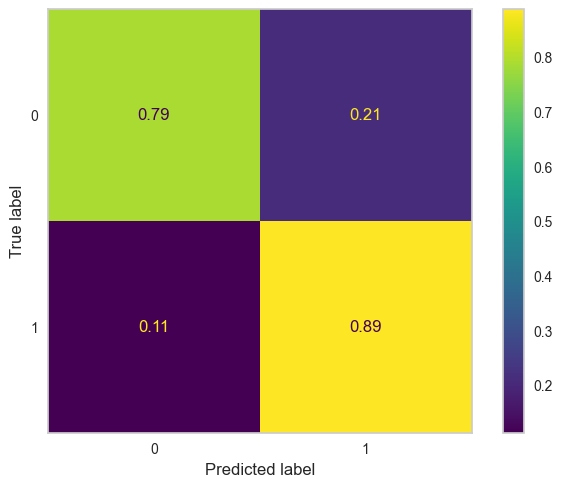

In [32]:
evaluation_plot(ET, x_test, y_test, y_pred_ET)

### 7. XGBoost

In [33]:
imba_pipeline = make_pipeline(XGBClassifier(eval_metric='mlogloss'))
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring ='accuracy',cv=kf)}")

XGB_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]}

new_params = {'xgbclassifier__' + key: XGB_params[key] for key in XGB_params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf,
                         scoring='accuracy', return_train_score=True)

XGB= grid_imba.fit(x_train, y_train)

print(f"Mean test score: {grid_imba.cv_results_['mean_test_score']}, \nMean train score: {grid_imba.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba.best_params_}")

Cross Validation Score:[0.86486486 0.87387387 0.84545455 0.87272727 0.85454545]
Mean test score: [0.87143325 0.85149877 0.87318591 0.87138411 0.86958231 0.86414414
 0.8641769  0.87321867 0.86594595 0.85873874 0.85870598 0.87136773
 0.87316953 0.86235872 0.86959869 0.8641769  0.86961507 0.86959869
 0.87497133 0.86234234 0.86594595 0.86958231 0.87323505 0.86963145
 0.8641769  0.86961507 0.86959869 0.86961507 0.8586896  0.86596233
 0.87321867 0.86778051 0.87505324 0.8641769  0.86778051 0.86230958
 0.85141687 0.85873874 0.87859132 0.85867322 0.86778051 0.86961507
 0.8641769  0.86958231 0.86776413 0.87859132 0.86055692 0.87135135
 0.85326781 0.86781327 0.87323505 0.8641769  0.86778051 0.86776413
 0.86773137 0.87136773 0.87687142 0.87140049 0.86958231 0.86776413
 0.86416052 0.87503686 0.86414414 0.8750041  0.86234234 0.86594595
 0.86054054 0.8786077  0.87503686 0.86416052 0.87503686 0.86414414
 0.86954955 0.85687142 0.87138411 0.86234234 0.87141687 0.86958231
 0.86416052 0.87323505 0.8641441

In [34]:
y_pred_XGB = XGB.predict(x_test)

In [35]:
XGB_measurement = measures('XGBoost', y_test, y_pred_XGB)

XGBoost Accuracy: 0.8116
XGBoost Precision: 0.7288
XGBoost Recall: 0.8113
XGBoost F1: 0.7679
XGBoost Cohen kappa: 0.6101


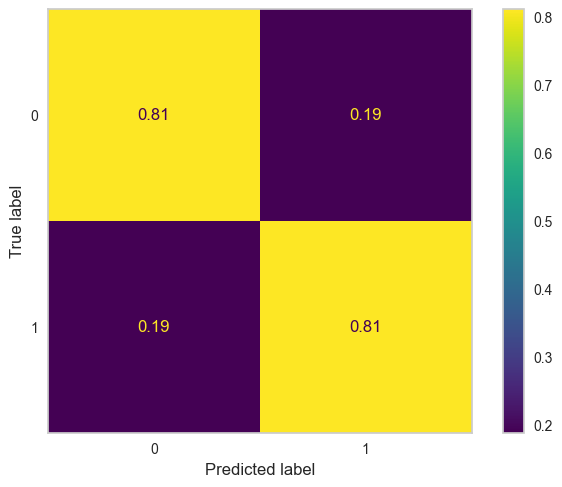

In [36]:
evaluation_plot(XGB, x_test, y_test, y_pred_XGB)

### 8. LightGBM

In [5]:
imba_pipeline = make_pipeline(LGBMClassifier())
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring ='accuracy',cv=kf)}")

LGBM_params = {'learning_rate': [0.1,0.2,0.3,0.4,0.5],
                'max_depth': [2,4,6],
                'num_leaves': [2,4,6],
                #'n_estimators': [5,6,7,8,9],
                'subsample': [0.2,0.4,0.6,0.8,1.0]}

new_params = {'lgbmclassifier__' + key: LGBM_params[key] for key in LGBM_params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf,
                         scoring='accuracy', return_train_score=True)

LGBM= grid_imba.fit(x_train, y_train)

print(f"Mean test score: {grid_imba.cv_results_['mean_test_score']}, \nMean train score: {grid_imba.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba.best_params_}")

Cross Validation Score:[0.83783784 0.88288288 0.88181818 0.88181818 0.85454545]
Mean test score: [0.87143325 0.87143325 0.87143325 0.87143325 0.87143325 0.87321867
 0.87321867 0.87321867 0.87321867 0.87321867 0.87321867 0.87321867
 0.87321867 0.87321867 0.87321867 0.87143325 0.87143325 0.87143325
 0.87143325 0.87143325 0.87138411 0.87138411 0.87138411 0.87138411
 0.87138411 0.87141687 0.87141687 0.87141687 0.87141687 0.87141687
 0.87143325 0.87143325 0.87143325 0.87143325 0.87143325 0.87138411
 0.87138411 0.87138411 0.87138411 0.87138411 0.86779689 0.86779689
 0.86779689 0.86779689 0.86779689 0.8822932  0.8822932  0.8822932
 0.8822932  0.8822932  0.86594595 0.86594595 0.86594595 0.86594595
 0.86594595 0.86594595 0.86594595 0.86594595 0.86594595 0.86594595
 0.8822932  0.8822932  0.8822932  0.8822932  0.8822932  0.8641769
 0.8641769  0.8641769  0.8641769  0.8641769  0.86597871 0.86597871
 0.86597871 0.86597871 0.86597871 0.8822932  0.8822932  0.8822932
 0.8822932  0.8822932  0.8641769  0

In [6]:
y_pred_LGBM = LGBM.predict(x_test)

In [7]:
LGBM_measurement = measures('LightGBM', y_test, y_pred_LGBM)

LightGBM Accuracy: 0.8406
LightGBM Precision: 0.746
LightGBM Recall: 0.8868
LightGBM F1: 0.8103
LightGBM Cohen kappa: 0.6746


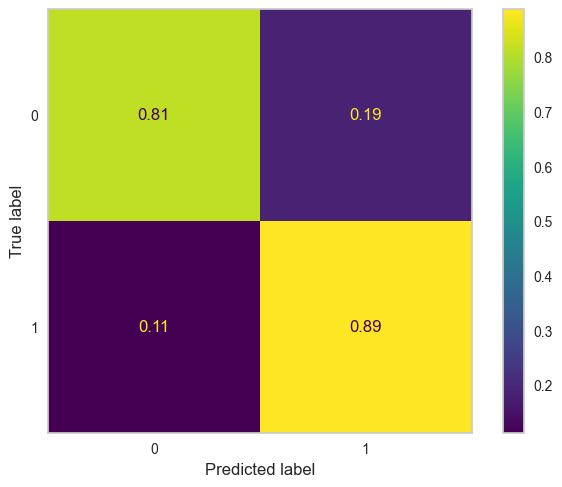

In [8]:
evaluation_plot(LGBM, x_test, y_test, y_pred_LGBM)

In [10]:
with open('LightGBM.pkl' , 'wb') as file:
  pickle.dump(LGBM, file)

### 9. MLP

In [41]:
imba_pipeline = make_pipeline(MLPClassifier())
print(f"Cross Validation Score:{cross_val_score(imba_pipeline, x_train, y_train, scoring ='accuracy',cv=kf)}")

MLP_params = {'hidden_layer_sizes': [(10, 5 , 2), (1, 3, 5), (5, 10, 5), (10, 5), (5,)],
              'activation': ['logistic', 'relu', 'tanh'],
              'max_iter':[100,110,120,130,140,150,160,170,180,190,200],
              'solver': ['sgd','adam', 'lbfgs'],
              'random_state': [0],
              'early_stopping': [True]}
new_params = {'mlpclassifier__' + key: MLP_params[key] for key in MLP_params}
grid_imba4 = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf,
                         scoring='accuracy', return_train_score=True)

MLP= grid_imba4.fit(x_train, y_train)

print(f"Mean test score: {grid_imba4.cv_results_['mean_test_score']}, \nMean train score: {grid_imba4.cv_results_['mean_train_score']}")
print(f"Grid search best score: {round(grid_imba4.best_score_, 4)}")
print(f"Grid search best parameters: {grid_imba4.best_params_}")


Cross Validation Score:[0.82882883 0.83783784 0.88181818 0.88181818 0.86363636]
Mean test score: [0.53970516 0.53970516 0.83338247 0.53970516 0.53970516 0.8370516
 0.53970516 0.53970516 0.84063882 0.53970516 0.53970516 0.84247338
 0.53970516 0.53970516 0.84247338 0.53970516 0.53970516 0.84607699
 0.53970516 0.53970516 0.83883702 0.53970516 0.53970516 0.84427518
 0.53970516 0.53970516 0.84791155 0.53970516 0.53970516 0.83883702
 0.53970516 0.53970516 0.84607699 0.46029484 0.46029484 0.85515152
 0.46029484 0.46029484 0.8587715  0.46029484 0.46029484 0.85878788
 0.46029484 0.46029484 0.86058968 0.46029484 0.46029484 0.8569697
 0.46029484 0.46029484 0.86058968 0.46029484 0.46029484 0.86240786
 0.46029484 0.46029484 0.86058968 0.46029484 0.46029484 0.8587715
 0.46029484 0.46029484 0.86058968 0.46029484 0.46029484 0.86239148
 0.46029484 0.46029484 0.83338247 0.46029484 0.46029484 0.82976249
 0.46029484 0.46029484 0.83334971 0.46029484 0.46029484 0.83336609
 0.46029484 0.46029484 0.82972973 0

In [42]:
y_pred_MLP = MLP.predict(x_test)

In [43]:
MLP_measurement = measures('MLP', y_test, y_pred_MLP)

MLP Accuracy: 0.8188
MLP Precision: 0.7121
MLP Recall: 0.8868
MLP F1: 0.7899
MLP Cohen kappa: 0.634


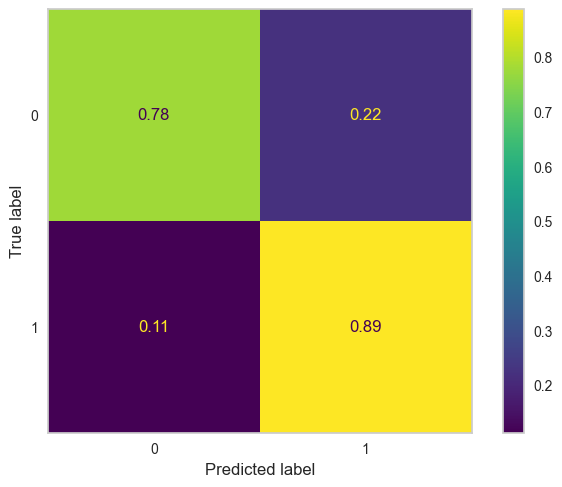

In [44]:
evaluation_plot(MLP, x_test, y_test, y_pred_MLP)

In [45]:
with open('MLP.pkl' , 'wb') as file:
  pickle.dump(MLP, file)

### ROC Curve Analysis for Classification Models

              classifiers                                                fpr  \
0     Logistic Regression  [0.0, 0.0, 0.0, 0.011764705882352941, 0.011764...   
1           Decision Tree  [0.0, 0.058823529411764705, 0.2705882352941176...   
2  Support Vector Machine  [0.0, 0.0, 0.011764705882352941, 0.01176470588...   
3                AdaBoost  [0.0, 0.0, 0.0, 0.03529411764705882, 0.0352941...   
4           Random Forest  [0.0, 0.0, 0.0, 0.011764705882352941, 0.011764...   
5              Extra Tree  [0.0, 0.0, 0.011764705882352941, 0.01176470588...   
6                 XGBoost  [0.0, 0.0, 0.0, 0.011764705882352941, 0.011764...   
7                LightGBM  [0.0, 0.0, 0.0, 0.023529411764705882, 0.023529...   
8  Multi-layer Perceptron  [0.0, 0.0, 0.0, 0.011764705882352941, 0.011764...   

                                                 tpr       auc  
0  [0.0, 0.018867924528301886, 0.1698113207547169...  0.907214  
1  [0.0, 0.6792452830188679, 0.9622641509433962, ...  0.908768  
2  [

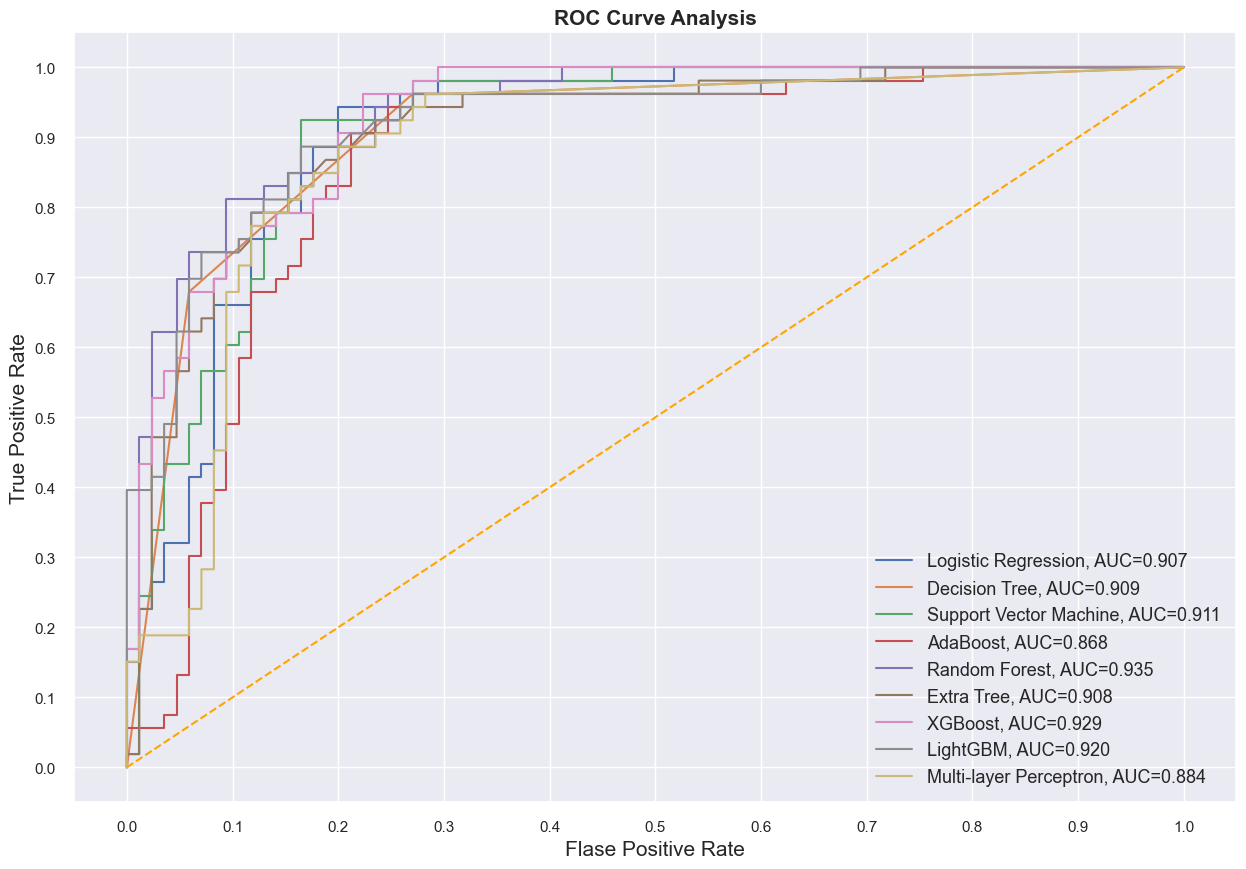

In [46]:
models_auc = []
models_probs = []
classifiers = [LR, DT, svm, AB, RF, ET, XGB, LGBM, MLP]
model_name = ['Logistic Regression', 'Decision Tree', 'Support Vector Machine',
             'AdaBoost', 'Random Forest', 'Extra Tree','XGBoost','LightGBM','Multi-layer Perceptron']
y_preds = [y_pred_LR, y_pred_DT, y_pred_SVM,
         y_pred_AB, y_pred_RF, y_pred_ET,
         y_pred_XGB, y_pred_LGBM, y_pred_MLP]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for y_pred,model in zip(y_preds,classifiers):
  yproba = model.predict_proba(x_test)[:,1]
  models_probs.append(y_pred)
  random_probs = [0 for i in range(len(y_test))]
  p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
  fpr, tpr, threshold = roc_curve(y_test, yproba, pos_label=1)
  auc = roc_auc_score(y_test, yproba)
  models_auc.append(auc)
  result_table = result_table.append({'classifiers':model_name[classifiers.index(model)],
                                      'fpr':fpr,
                                      'tpr':tpr,
                                      'auc':auc}, ignore_index=True)


print(result_table) 
models_auc = pd.DataFrame(models_auc, index=model_name)
models_probs = pd.DataFrame(models_probs, index=model_name).T
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(15,10))
sns.set_theme(style="darkgrid")

for i in result_table.index:
   plt.plot(result_table.loc[i]['fpr'], 
            result_table.loc[i]['tpr'],
            label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))


plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()
    


###  Evaluation Metrics Comparison for Classification Models

In [47]:

model_names = ['Logistic Regression', 'Decision Tree Classifier',
               'Support Vector Machine','AdaBoost', 'Random Forest',
               'Extra Tree Classifier', 'XGBoost','LightGBM',
               'Multi-Layer Perceptron']

measurements = [LR_measurement,DT_measurement,
                SVM_measurement,AB_measurement,
                RF_measurement,ET_measurement,
                XGB_measurement,LGBM_measurement,
                MLP_measurement]

eval_met = []

# Populate eval_met list with measurement dictionaries
for model_name, measurement in zip(model_names, measurements):
    eval_dict = {
        'Model': model_name,
        'Accuracy': measurement[0],
        'Precision': measurement[1],
        'Recall': measurement[2],
        'F1': measurement[3],
        'Chen kappa': measurement[4]
    }
    eval_met.append(eval_dict)

# Convert eval_met list of dictionaries into a DataFrame
eval_met = pd.DataFrame(eval_met)

print(tabulate(eval_met, headers= 'keys', tablefmt='fancy_grid'))

╒════╤══════════════════════════╤════════════╤═════════════╤══════════╤════════╤══════════════╕
│    │ Model                    │   Accuracy │   Precision │   Recall │     F1 │   Chen kappa │
╞════╪══════════════════════════╪════════════╪═════════════╪══════════╪════════╪══════════════╡
│  0 │ Logistic Regression      │     0.8261 │      0.7042 │   0.9434 │ 0.8065 │       0.6545 │
├────┼──────────────────────────┼────────────┼─────────────┼──────────┼────────┼──────────────┤
│  1 │ Decision Tree Classifier │     0.8188 │      0.6892 │   0.9623 │ 0.8031 │       0.6437 │
├────┼──────────────────────────┼────────────┼─────────────┼──────────┼────────┼──────────────┤
│  2 │ Support Vector Machine   │     0.8116 │      0.6849 │   0.9434 │ 0.7937 │       0.6282 │
├────┼──────────────────────────┼────────────┼─────────────┼──────────┼────────┼──────────────┤
│  3 │ AdaBoost                 │     0.8188 │      0.7333 │   0.8302 │ 0.7788 │       0.6264 │
├────┼──────────────────────────┼───────